<a href="https://www.kaggle.com/code/shravankumar147/control-image-generation-prompt-weighting-compel?scriptVersionId=204616034" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
!pip install --upgrade diffusers[torch] --q

In [6]:
!pip install compel --q

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


# Control image generation
Trying to generate an image that looks exactly the way you want can be difficult, which is why controlled generation techniques and models are so useful. While you can use the negative_prompt to partially control image generation, there are more robust methods like prompt weighting and ControlNets.

## Prompt weighting
Prompt weighting allows you to scale the representation of each concept in a prompt. For example, in a prompt like “Astronaut in a jungle, cold color palette, muted colors, detailed, 8k”, you can choose to increase or decrease the embeddings of “astronaut” and “jungle”. The Compel library provides a simple syntax for adjusting prompt weights and generating the embeddings. You can learn how to create the embeddings in the Prompt weighting guide.

AutoPipelineForImage2Image has a prompt_embeds (and negative_prompt_embeds if you’re using a negative prompt) parameter where you can pass the embeddings which replaces the prompt parameter.

In [4]:
from diffusers import AutoPipelineForImage2Image
import torch

pipeline = AutoPipelineForImage2Image.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
)
pipeline.enable_model_cpu_offload()
# remove following line if xFormers is not installed or you have PyTorch 2.0 or higher installed
# pipeline.enable_xformers_memory_efficient_attention()

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/608M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [11]:
pipeline

StableDiffusionImg2ImgPipeline {
  "_class_name": "StableDiffusionImg2ImgPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "stable-diffusion-v1-5/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

Ref: https://github.com/damian0815/compel

In [7]:
from compel import Compel

In [12]:
compel = Compel(tokenizer=pipeline.tokenizer, text_encoder=pipeline.text_encoder)

In [27]:
# upweight "ball"
# prompt = "a cat playing with a ball++ in the forest"
prompt = "Astronaut in a jungle_, cold color palette, muted colors, detailed, 8k"
negative_prompt = "ugly, deformed, disfigured, poor details, bad anatomy"

# conditioning = compel.build_conditioning_tensor(prompt)
# or: conditioning = compel([prompt])

In [32]:
# prompt = "a cat playing with a ball++ in the forest, amazing, exquisite, stunning, masterpiece, skilled, powerful, incredible, amazing, trending on gregstation, greg, greggy, greggs greggson, greggy mcgregface, ..." # very long prompt
prompt_embeds = compel.build_conditioning_tensor(prompt)
negative_prompt = "" # it's necessary to create an empty prompt - it can also be very long, if you want
negative_prompt_embeds = compel.build_conditioning_tensor(negative_prompt)
[prompt_embeds, negative_prompt_embeds] = compel.pad_conditioning_tensors_to_same_length([prompt_embeds, negative_prompt_embeds])

In [33]:
from diffusers.utils import make_image_grid, load_image
# prepare image
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/img2img-init.png"
init_image = load_image(url)

In [36]:
image = pipeline(prompt_embeds=prompt_embeds, # generated from Compel
    negative_prompt_embeds=negative_prompt_embeds, # generated from Compel
    image=init_image,
).images[0]

  0%|          | 0/40 [00:00<?, ?it/s]

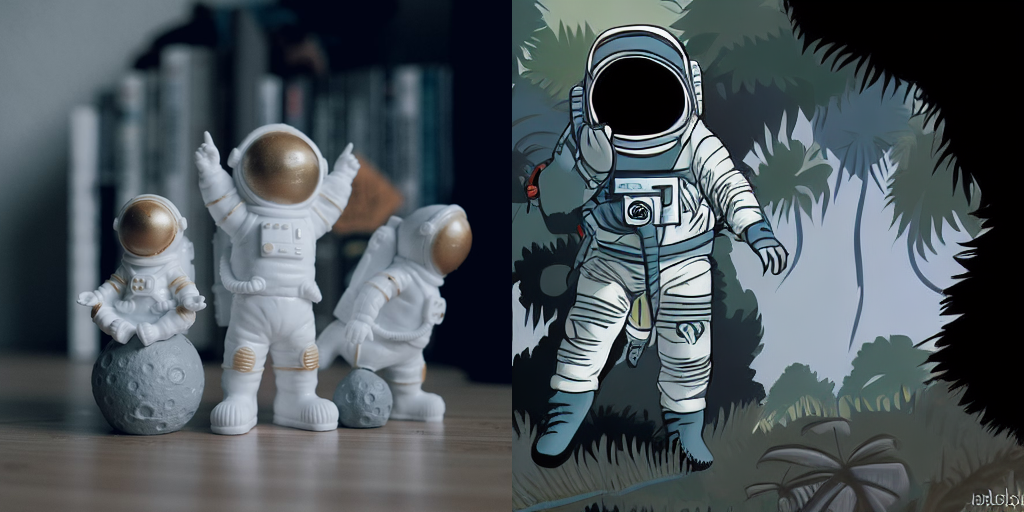

In [37]:
make_image_grid([init_image, image], rows=1, cols=2)